In [1]:
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

from time import sleep

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add
from tensorflow.initializers import glorot_normal, lecun_normal
from scipy.ndimage import median_filter
from skimage.transform import resize

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [2]:
%run ../../src/layers/zoneout.py
%run ../../src/layers/adabound.py
%run ../../src/layers/convgru.py
%run ../../src/layers/dropblock.py
%run ../../src/layers/extra_layers.py
%run ../../src/preprocessing/indices.py
%run ../../src/preprocessing/slope.py


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [3]:
def cse_block(prevlayer, prefix):
    '''Channel excitation and spatial squeeze layer. 
       Calculates the mean of the spatial dimensions and then learns
       two dense layers, one with relu, and one with sigmoid, to rerank the
       input channels
       
         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the cse_block
    '''
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x


def sse_block(prevlayer, prefix):
    '''Spatial excitation and channel squeeze layer.
       Calculates a 1x1 convolution with sigmoid activation to create a 
       spatial map that is multiplied by the input layer

         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the sse_block
    '''
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''Implementation of Concurrent Spatial and Channel 
       ‘Squeeze & Excitation’ in Fully Convolutional Networks
    
        Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): added output of cse and sse block
          
         References:
          https://arxiv.org/abs/1803.02579
    '''
    #cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    #x = Add(name=prefix + "_csse_mul")([cse, sse])

    return sse

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        print("ZERO PADDING")
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
    
class ReflectionPadding5D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding5D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        print("ZERO PADDING")
        return tf.pad(x, [[0,0], [0, 0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [4]:
def gru_block(inp, length, size, flt, scope, train, normalize = True):
    '''Bidirectional convolutional GRU block with 
       zoneout and CSSE blocks in each time step

         Parameters:
          inp (tf.Variable): (B, T, H, W, C) layer
          length (tf.Variable): (B, T) layer denoting number of
                                steps per sample
          size (int): kernel size of convolution
          flt (int): number of convolution filters
          scope (str): tensorflow variable scope
          train (tf.Bool): flag to differentiate between train/test ops
          normalize (bool): whether to compute layer normalization

         Returns:
          gru (tf.Variable): (B, H, W, flt*2) bi-gru output
          steps (tf.Variable): (B, T, H, W, flt*2) output of each step
    '''
    with tf.variable_scope(scope):
        print(f"GRU input shape {inp.shape}, zoneout: {0.1}")
        """
        cell_fw = ConvLSTMCell(shape = size, filters = flt,
                               kernel = [3, 3], forget_bias=1.0, 
                               activation=tf.tanh, normalize=True, 
                               peephole=False, data_format='channels_last', reuse=None)
        cell_bw = ConvLSTMCell(shape = size, filters = flt,
                               kernel = [3, 3], forget_bias=1.0, 
                               activation=tf.tanh, normalize=True, 
                               peephole=False, data_format='channels_last', reuse=None)
        """
        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, sse = True)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, sse = True)
        zoneout = 0.8
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = zoneout, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = zoneout, is_training = train)
        print(inp.shape)
        steps, out = convGRU(inp, cell_fw, cell_bw, length)
        print(f"Zoneout: {zoneout}")
        gru = tf.concat(out, axis = -1)
        steps = tf.concat(steps, axis = -1)
        print(f"Down block output shape {gru.shape}")
    return gru, steps

In [5]:
def conv_swish_gn(inp, 
                 is_training, 
                 kernel_size,
                 scope,
                 filters, 
                 keep_rate,
                 stride = (1, 1),
                 activation = True,
                 use_bias = False,
                 norm = True,
                 dropblock = True,
                 csse = True,
                 weight_decay = None,
                 block_size = 5,
                 padding = "SAME"):
    '''2D convolution, batch renorm, relu block, 3x3 drop block. 
       Use_bias must be set to False for batch normalization to work. 
       He normal initialization is used with batch normalization.
       RELU is better applied after the batch norm.
       DropBlock performs best when applied last, according to original paper.

         Parameters:
          inp (tf.Variable): input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): size of convolution
          scope (str): tensorflow variable scope
          filters (int): number of filters for convolution
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization
          activation (bool): whether to apply RELU
          use_bias (str): whether to use bias. Should always be false

         Returns:
          bn (tf.Variable): output of Conv2D -> Batch Norm -> RELU
        
         References:
          http://papers.nips.cc/paper/8271-dropblock-a-regularization-
              method-for-convolutional-networks.pdf
          https://arxiv.org/abs/1702.03275
          
    '''
    
    bn_flag = "Group Norm" if norm else ""
    activation_flag = "RELU" if activation else "Linear"
    csse_flag = "CSSE" if csse else "No CSSE"
    bias_flag = "Bias" if use_bias else "NoBias"
    drop_flag = "DropBlock" if dropblock else "NoDrop"
        
    
    print("{} {} Conv 2D {} {} {} {} {}".format(scope, kernel_size,
                                                   bn_flag, activation_flag,
                                                   csse_flag, bias_flag, drop_flag))
    
    with tf.variable_scope(scope + "_conv"):
        conv = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),  strides = stride,
                      activation = None, padding = 'valid', use_bias = use_bias,
                      #kernel_regularizer = weight_decay,
                      kernel_initializer = tf.keras.initializers.he_normal())(inp)
        #conv = partial_conv(inp, filters, kernel=kernel_size, stride=1, 
        #                    use_bias=False, padding=padding, scope = scope)
    if activation:
        conv = tf.nn.swish(conv)
    #
    if norm:
        conv = group_norm(x = conv, scope = scope, G = 8)
    if csse:
        conv = csse_block(conv, "csse_" + scope)
    if dropblock: 
        with tf.variable_scope(scope + "_drop"):
            drop_block = DropBlock2D(keep_prob=keep_rate, block_size= block_size)
            conv = drop_block(conv, is_training)
    return conv

In [6]:
INPUT_SIZE = 28

n_bands = 17
inp = tf.placeholder(tf.float32, shape=(None, 13, INPUT_SIZE, INPUT_SIZE, n_bands))
length = tf.placeholder_with_default(np.full((1,), 12), shape = (None,))
labels = tf.placeholder(tf.float32, shape=(None, INPUT_SIZE - 14, INPUT_SIZE - 14))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
is_training = tf.placeholder_with_default(False, (), 'is_training') # For BN, DropBlock
alpha = tf.placeholder(tf.float32, shape = ()) # For loss scheduling
ft_lr = tf.placeholder_with_default(0.001, shape = ()) # For loss scheduling
loss_weight = tf.placeholder_with_default(1.0, shape = ())
beta_ = tf.placeholder_with_default(0.0, shape = ())

In [7]:
initial_flt = 32
mid_flt = 32 * 2
high_flt = 32 * 2 * 2

gru_input = inp[:, :12, ...]
gru, steps = gru_block(inp = gru_input, length = length,
                            size = [28, 28],
                            flt = initial_flt // 2,
                            scope = 'down_16',
                            train = is_training)
with tf.variable_scope("gru_drop"):
    drop_block = DropBlock2D(keep_prob=keep_rate, block_size=4)
    gru = drop_block(gru, is_training)
    
# Median conv
median_input = inp[:, -1, ...]
median_input = ReflectionPadding2D((1, 1,))(median_input)
median_conv = conv_swish_gn(inp = median_input, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv_median', filters = initial_flt, 
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None)
print(f"Median conv: {median_conv.shape}")

concat = tf.concat([gru, median_conv], axis = -1)
concat = ReflectionPadding2D((1, 1,))(concat)
concat = conv_swish_gn(inp = concat, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv_concat', filters = initial_flt,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None, padding = "VALID")
print(f"Concat: {concat.shape}")

# MaxPool-conv-swish-GroupNorm-csse
pool1 = MaxPool2D()(concat)
conv1 = conv_swish_gn(inp = pool1, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv1', filters = mid_flt,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None)
print(f"Conv1: {conv1.shape}")

# MaxPool-conv-swish-csse-DropBlock
pool2 = MaxPool2D()(conv1)
conv2 = conv_swish_gn(inp = pool2, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv2', filters = high_flt, 
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None, block_size = 4, padding = "VALID")
print("Encoded", conv2.shape)

# Decoder 4 - 8, upsample-conv-swish-csse-concat-conv-swish
up2 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(conv2)
up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2', filters = mid_flt, 
                    keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None)
conv1_crop = Cropping2D(2)(conv1)

up2 = tf.concat([up2, conv1_crop], -1)
up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2_out', filters = mid_flt, 
                    keep_rate =  keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None, padding = "VALID")

# Decoder 8 - 14 upsample-conv-swish-csse-concat-conv-swish
up3 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(up2)
up3 = ReflectionPadding2D((1, 1,))(up3)
up3 = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up3', filters = initial_flt, 
                    keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None)
gru_crop = Cropping2D(6)(concat)
up3 = tf.concat([up3, gru_crop], -1)

up3 = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'out', filters = initial_flt, 
                    keep_rate  = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = False, weight_decay = None, padding = "VALID")

init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
print(f"The output is {up2.shape}, with a receptive field of {1}")
fm = Conv2D(filters = 1,
            kernel_size = (1, 1),
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init,
           )(up3) # For focal loss
print(f"The output, sigmoid is {fm.shape}, with a receptive field of {1}")

GRU input shape (?, 12, 28, 28, 17), zoneout: 0.1
(?, 12, 28, 28, 17)

(3, 3, 33, 32)
(3, 3, 33, 32)
Zoneout: 0.8
Down block output shape (?, 28, 28, 32)


ZERO PADDING
conv_median 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
Median conv: (?, 28, 28, 32)
ZERO PADDING
conv_concat 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
Concat: (?, 28, 28, 32)
conv1 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
Conv1: (?, 12, 12, 64)
conv2 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
Encoded (?, 4, 4, 128)
ZERO PADDING
up2 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
ZERO PADDING
up2_out 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
ZERO PADDING
up3 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
out 3 Conv 2D Group Norm RELU CSSE NoBias NoDrop
The output is (?, 8, 8, 64), with a receptive field of 1
The output, sigmoid is (?, 14, 14, 1), with a receptive field of 1


In [8]:
from keras.losses import binary_crossentropy
import math
from scipy.ndimage import distance_transform_edt as distance

def calc_mask(seg):

    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)
    loss_importance = np.array([x for x in range(0, 197, 1)])
    loss_importance = loss_importance / 196
    loss_importance = np.expm1(loss_importance)
    loss_importance[:30] = 0.

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    res[np.logical_and(res < 2, res > 0)] = 0.5
    res[np.logical_or(res >= 2, res <= 0)] = 1.
    return res

def calc_mask_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    bce_batch = np.array([calc_mask(y)
                     for y in y_true_numpy]).astype(np.float32)
    return bce_batch

def weighted_bce_loss(y_true, y_pred, weight, mask = True, smooth = 0.03):
    '''Calculates the weighted binary cross entropy loss between y_true and
       y_pred with optional masking and smoothing for regularization
       
       For smoothing, we want to weight false positives as less important than
       false negatives, so we smooth false negatives 2x as much. 
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          weight (float):
          mask (arr):
          smooth (float):

         Returns:
          loss (float):
    '''
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    y_true = K.clip(y_true, smooth, 1. - smooth)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )

    return loss

def calc_dist_map(seg):
    #Utility function for calc_dist_map_batch that calculates the loss
    #   importance per pixel based on the surface distance function
    
     #    Parameters:
    #      seg (arr):
     #     
    #     Returns:
    #      res (arr):
    #
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    mults = np.ones_like(seg)
    ones = np.ones_like(seg)
    for x in range(1, res.shape[0] -1 ):
        for y in range(1, res.shape[0] - 1):
            if seg[x, y] == 1:
                l = seg[x - 1, y]
                r = seg[x + 1, y]
                u = seg[x, y + 1]
                d = seg[x, y - 1]
                lu = seg[x - 1, y + 1]
                ru = seg[x + 1, y + 1]
                rd = seg[x + 1, y - 1]
                ld = seg[x -1, y - 1]
                
                sums = (l + r + u + d)
                sums2 = (l + r + u + d + lu + ru +rd + ld)
                if sums >= 2:
                    mults[x, y] = 2
                if sums2 <= 1:
                    ones[x - 1, y] = 0.5
                    ones[x + 1, y] = 0.5
                    ones[x, y + 1] = 0.5
                    ones[x, y - 1] = 0.5
                    ones[x - 1, y + 1] = 0.5
                    ones[x + 1, y + 1] = 0.5
                    ones[x + 1, y - 1] = 0.5
                    ones[x -1, y - 1] = 0.5

    if posmask.any():
        
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        # When % = 1, 0 -> 1.75
        # When % = 100, 0 -> 0
        res = np.round(res, 0)
        res[np.where(np.isclose(res, -.41421356, rtol = 1e-2))] = -1
        res[np.where(res == -1)] = -1 * mults[np.where(res == -1)]
        res[np.where(res == 0)] = -1  * mults[np.where(res == 0)]
        # When % = 1, 1 -> 0
        # When % = 100, 1 -> 1.75
        res[np.where(res == 1)] = 1 * ones[np.where(res == 1)]
        res[np.where(res == 1)] *= 0.67
        #res[np.where(np.isclose(res, 1.41421356, rtol = 1e-2))] = loss_importance[sums]
        
    res[np.where(res < -3)] = -3
    res[np.where(res > 3)] = 3
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
        res *= -1
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    return res


def calc_dist_map_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)

def surface_loss(y_true, y_pred):
    '''Calculates the mean surface loss for the input batch
       by multiplying the distance map by y_pred
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          
         Returns:
          loss (arr):
        
         References:
          https://arxiv.org/abs/1812.07032
    '''
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    y_true_dist_map = tf.stack(y_true_dist_map, axis = 0)
    multipled = y_pred * y_true_dist_map
    loss = tf.reduce_mean(multipled, axis = (1, 2, 3))
    return loss


def lovasz_surf(y_true, y_pred, alpha, weight, beta):

    bce = weighted_bce_loss(y_true = y_true, 
                             y_pred = y_pred, 
                             weight = weight,
                             smooth = 0.03)

    bce = tf.reduce_mean(bce, axis = (1, 2, 3))
    surface = surface_loss(y_true, y_pred)

    surface = tf.reduce_mean(surface)


    bce = tf.reduce_mean(bce)
    bce = (1 - alpha) * bce
    surface_portion = alpha * surface
    
    #result = bce + lovasz
    result = bce + surface_portion
    return result

In [9]:
%run ../../src/layers/adabound.py
def grad_norm(gradients):
        norm = tf.norm(
            tf.stack([
                tf.norm(grad) for grad in gradients if grad is not None
            ])
        )
        return norm
    

optimizer = AdaBoundOptimizer(1e-3, ft_lr)
train_loss = lovasz_surf(tf.reshape(labels, (-1, INPUT_SIZE - 14, INPUT_SIZE - 14, 1)), 
                         fm, weight = loss_weight, 
                         alpha = alpha, beta = beta_)
l2_loss = tf.losses.get_regularization_loss()
if len(tf.losses.get_regularization_losses()) > 0:
    print("Adding L2 loss")
    train_loss = train_loss + l2_loss

test_loss = lovasz_surf(tf.reshape(labels, (-1, INPUT_SIZE - 14, INPUT_SIZE - 14, 1)),
                        fm, weight = loss_weight, 
                        alpha = alpha, beta = beta_)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(train_loss)   

trainable_params = tf.trainable_variables()
gradients = optimizer.compute_gradients(loss=train_loss, var_list=None)
gradient_norm = grad_norm(gradients)
scale = 0.05 / (gradient_norm + 1e-12)
e_ws = []
for (grad, param) in gradients:
    e_w = grad * scale
    param.assign_add(e_w)
    e_ws.append(e_w)

sam_gradients = optimizer.compute_gradients(loss=train_loss, var_list=None)
for (param, e_w) in zip(trainable_params, e_ws):
    param.assign_sub(e_w)
train_step = optimizer.apply_gradients(sam_gradients)


init_op = tf.global_variables_initializer()
sess.run(init_op)
saver = tf.train.Saver(max_to_keep = 150)

In [10]:
path = "../../models/small-temporal/"
saver.restore(sess, tf.train.latest_checkpoint(path))

INFO:tensorflow:Restoring parameters from ../../models/small-temporal/model


In [140]:
def convert_to_db(x, min_db):
    x = 10 * np.log10(x + 1/65535)
    x[x < -min_db] = -min_db
    x = x + min_db
    x = x / min_db
    x = np.clip(x, 0, 1)
    return x


def grndvi(array):
    nir = np.clip(array[..., 3], 0, 1)
    green = np.clip(array[..., 1], 0, 1)
    red = np.clip(array[..., 2], 0, 1)
    denominator = (nir+(green+red)) + 1e-5
    return (nir-(green+red)) / denominator


def evi(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    '''
    Calculates the enhanced vegetation index
    2.5 x (08 - 04) / (08 + 6 * 04 - 7.5 * 02 + 1)
    '''

    BLUE = x[..., 0]
    GREEN = x[..., 1]
    RED = x[..., 2]
    NIR = x[..., 3]
    evis = 2.5 * ( (NIR-RED) / (NIR + (6*RED) - (7.5*BLUE) + 1))
    evis = np.clip(evis, -1.5, 1.5)
    return evis


def msavi2(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    '''
    Calculates the modified soil-adjusted vegetation index 2
    (2 * NIR + 1 - sqrt((2*NIR + 1)^2 - 8*(NIR-RED)) / 2
    '''
    BLUE = x[..., 0]
    GREEN = x[..., 1]
    RED = np.clip(x[..., 2], 0, 1)
    NIR = np.clip(x[..., 3], 0, 1)

    msavis = (2 * NIR + 1 - np.sqrt( (2*NIR+1)**2 - 8*(NIR-RED) )) / 2
    return msavis


def bi(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    B11 = np.clip(x[..., 8], 0, 1)
    B4 = np.clip(x[..., 2], 0, 1)
    B8 = np.clip(x[..., 3], 0, 1)
    B2 = np.clip(x[..., 0], 0, 1)
    bis = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))
    return bis

In [141]:
min_all = [0.006576638437476157, 0.0162050812542916, 0.010040436408026246, 0.013351644159609368, 0.01965362020294499, 0.014229037918669413, 0.015289539940489814, 0.011993591210803388, 0.008239871824216068, 0.006546120393682765, 0.0, 0.0, 0.0, -0.1409399364817101, -0.4973397113668104, -0.09731556326714398, -0.7193834232943873]
max_all = [0.2691233691920348, 0.3740291447318227, 0.5171435111009385, 0.6027466239414053, 0.5650263218127718, 0.5747005416952773, 0.5933928435187305, 0.6034943160143434, 0.7472037842374304, 0.7000076295109483, 0.509269855802243, 0.948334642387533, 0.6729257769285485, 0.8177635298774327, 0.35768999002433816, 0.7545951919107605, 0.7602693339366691]

In [142]:
import hickle as hkl
test_x = hkl.load("../../data/test/test_x.hkl")
test_y = hkl.load("../../data/test/test_y.hkl")
test_data = pd.read_csv("../../data/test/test_plot_ids.csv")

test_x = np.delete(test_x, 11, -1)
print(test_x.shape)

if not isinstance(test_x.flat[0], np.floating):
    assert np.max(test_x) > 1
    test_x = test_x / 65535.
    
test_x[..., -1] = convert_to_db(test_x[..., -1], 22)
test_x[..., -2] = convert_to_db(test_x[..., -2], 22)

indices = np.empty((test_x.shape[0], 12, 28, 28, 4))
indices[..., 0] = evi(test_x)
indices[..., 1] = bi(test_x)
indices[..., 2] = msavi2(test_x)
indices[..., 3] = grndvi(test_x)

test_x = np.concatenate([test_x, indices], axis = -1)
med = np.median(test_x, axis = 1)
med = med[:, np.newaxis, :, :, :]
test_x = np.concatenate([test_x, med], axis = 1)

below_1 = [i for i, val in enumerate(test_x[..., :-2]) if np.min(val) < -1.66]
above_1 = [i for i, val in enumerate(test_x[..., :-2]) if np.max(val) > 1.66]
nans = [i for i, val in enumerate(test_x) if np.sum(np.isnan(val)) > 0]
outliers = below_1 + above_1 + nans
outliers = list(set(outliers))

print(f"There are {len(outliers)} outliers")
print([x for x in test_data['plot_id'].iloc[outliers]])

test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data = test_data.reset_index(drop = True)

(406, 12, 28, 28, 13)
There are 0 outliers
[]


In [143]:
for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[..., band] = np.clip(test_x[..., band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[..., band] - midrange) / (rng / 2)
    test_x[..., band] = standardized
print("Finished data scaling")

Finished data scaling


In [144]:
def multiplot(matrices, nrows = 2, ncols = 4):
    '''Docstring
    
         Parameters:
          matrices (list):
          nrows (int):
          
         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(18, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9, cbar = False)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show

In [148]:
start = 292



0.7192118226600985
[292, 293, 294, 295, 296, 297, 298, 299]
292 9.731321416809351 38.750904399999996
293 8.6053405928307 38.01012753999999
294 -32.16701769948428 28.557814829999995
295 -30.77435720949694 26.661426070000008
296 -27.72235654952877 29.980106400000004
297 -32.34480414948275 18.51288063
298 -29.203910269512626 25.50581417
299 13.138894969746664 -9.310698178999996


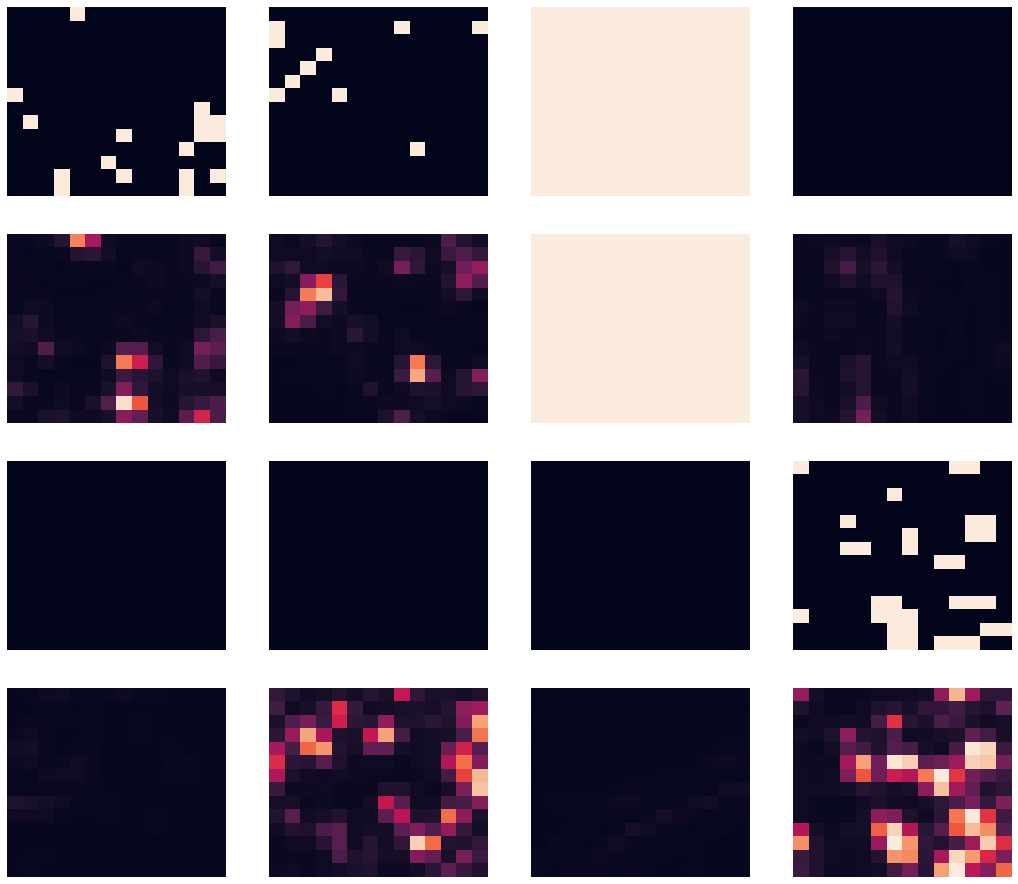

In [149]:
test_ids = [x for x in range(len(test_x))]
print(start/len(test_ids))
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]

preds = []
trues = []

print(matrix_ids)
for i in matrix_ids:
    idx = i
    x_input = test_x[idx].reshape(1, 13, 28, 28, n_bands)
    y = sess.run([fm], feed_dict={inp: x_input,
                                  length: np.full((1,), 12),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    print(i, test_data.iloc[i]['lat'], test_data.iloc[i]['long'])
    preds.append(y)
    y2 = np.copy(y)
    true = test_y[idx].reshape(14, 14)
    trues.append(true)


to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]

multiplot(to_plot, nrows = 4, ncols = 4)

start = start + 8 

In [139]:
list(test_data.iloc[[231, 295]]['plot_id'])

[141018567, 141018709]